# 0. Подключение Google Colaboratory

In [1]:
# Подключение Google Drive к виртуальной машине
from google.colab import drive
drive.mount('/content/drive')

# Копирование данных с Google Drive на локальный диск виртуальной машины.
!cp -r /content/drive/MyDrive/Данные/X_train_ptbxl_superdiag.npy .
!cp -r /content/drive/MyDrive/Данные/X_val_ptbxl_superdiag.npy .
!cp -r /content/drive/MyDrive/Данные/y_train_ptbxl_superdiag.npy .
!cp -r /content/drive/MyDrive/Данные/y_val_ptbxl_superdiag.npy .

Mounted at /content/drive


# 1. Подключение пакетов и инициализация необходимых функций 

In [2]:
!pip install --upgrade tslearn wfdb sktime tsaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.2/358.2 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 75.5 MB/s eta 0:00:00
  Attempting uninstall: SoundFile
    Found existing installation: soundfile 0.12.1
    Uninstalling soundfile-0.12.1:
      Successfully uninstalled soundfile-0.12.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
librosa 0.10.0.post2 requires soundfile>=0.12.1, but you have soundfile 0.11.0 which is incompatible.


In [3]:
# data
# system
import os
import time
import math
import ast
import random
# wfdb
import wfdb
# tqdm
from tqdm import tqdm
# numpy and pandas
import pandas as pd
import numpy as np
# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# tslearn
from tslearn.utils import to_time_series, to_time_series_dataset, save_time_series_txt, load_time_series_txt
from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesResampler, TimeSeriesScalerMeanVariance
# sktime
from sktime.transformations.panel.compose import ColumnConcatenator
# tsaug
from tsaug import AddNoise

# visualization
# matplotlib
import matplotlib.pyplot as plt
# seaborn
import seaborn as sns
# sktime
from sktime.utils.plotting import plot_series

# metrics
# sklearn
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, pairwise_distances, classification_report
# sktime
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError, MeanSquaredError, mean_absolute_percentage_error

# model
# sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.calibration import CalibratedClassifierCV
# sktime
from sktime.classification.interval_based import TimeSeriesForestClassifier, DrCIF
from sktime.classification.kernel_based import RocketClassifier
# tslearn
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.svm import TimeSeriesSVC
# tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras import optimizers
from keras import layers

np.random.seed(42)



In [4]:
# Transformations

def fourier_transform(X, coeffs=80):
    X_ft = np.empty_like(X)
    for i in range(len(X)):
        sample_fft = np.fft.rfft(X[i].T)
        indices = np.array([[j < coeffs for j, _ in enumerate(sample_fft[k])] for k in range(len(sample_fft))])
        X_ft[i] = np.fft.irfft(indices * sample_fft).T
    
    return X_ft

def rolling_average(X, n=4): # n - размер окна
    shape = list(X.shape)
    shape[1] -= n-1 
    X_ra = np.empty(shape)
    for i in range(len(X)):
        sample = X[i].T
        X_ra[i] = np.array([np.convolve(signal, np.ones(n), 'valid') / n for signal in sample]).T
    return X_ra

# Metrics and confusion matrix

def draw_confusion_matrix(y, y_pred):
    print(classification_report(y, y_pred))
    sns.heatmap(confusion_matrix(y, y_pred), square=True, annot=True, fmt='.0f', cmap=plt.cm.Blues)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    pass

def draw_confusion_matrix_NN(X_test, y_test, model):
    y_pred = model.predict(X_test)
    print('score: ', model.evaluate(X_test, y_test))
    sns.heatmap(confusion_matrix(y_test, y_pred), square=True, annot=True, fmt='.0f', cmap=plt.cm.Blues)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    pass

def elimination_imbalance(X, y):
  n_classes = y.shape[1]
  unique = np.unique(y, axis = 0)
  for i in range(n_classes):
    index_want = (np.where((y == unique[i]).all(axis=1))[0])
    num_want = math.floor(index_want.shape[0]/100)*100
    if(num_want > 2000):
      num_want = 2000
    count_of_del = index_want.shape[0] - num_want
    index_to_remove = np.random.choice(np.where((y == unique[i]).all(axis=1))[0], size=count_of_del, replace=False)
    X = np.delete(X, index_to_remove, axis=0)
    y = np.delete(y, index_to_remove, axis=0)
  return X, y

def count_of_class(X, y):
  n_classes = y.shape[1]
  unique = np.unique(y, axis = 0)
  for i in range(n_classes):
    print(np.where((y == unique[i]).all(axis=1))[0].shape[0])

def plot_ts(x):
  plt.figure(figsize=(14, 3))
  plt.plot(x[0], 'o-', linewidth=1, markeredgewidth=0.01, alpha = 0.5 ) # все 12 отведений
  plt.xlabel('time', fontsize = 14)
  plt.title('Plotting a time series', fontsize = 16)
  plt.tight_layout()
  plt.show()

# Стандартизация 3D данных c применением StandardScaler.
# Сначала изменяется форма данных а затем применяется нормализация. После этого требуется вернуть их прежнюю форму 
def standard_scaler(X_train, X_test): 
  scaler = StandardScaler()
  # Train
  num_instances, num_time_steps, num_features = X_train.shape
  X_train = np.reshape(X_train, newshape=(-1, num_features))
  X_train = scaler.fit_transform(X_train)
  X_train = np.reshape(X_train, newshape=(num_instances, num_time_steps, num_features))
  # Test
  num_instances, num_time_steps, num_features = X_test.shape
  X_test = np.reshape(X_test, newshape=(-1, num_features))
  X_test = scaler.transform(X_test)
  X_test = np.reshape(X_test, newshape=(num_instances, num_time_steps, num_features))
  return X_train, X_test

def list_sum(X):
  X_sum = []
  for i in X:
    X_sum.append(np.reshape(i, X.shape[1]*X.shape[2], order = 'A'))
  X_sum = np.array(X_sum)
  return X_sum

def del_multi_class(X, y):
  X = X[np.array([sum(x) for x in y]) == 1]
  y = y[np.array([sum(x) for x in y]) == 1]
  return X, y

# Аугментация данных
def aug(X, y):
  aug = AddNoise(scale=(0.01, 0.05))
  selected_X = X[(y == [0, 1, 0, 0, 0]).all(axis = 1)] # Выбрали конкретное значение для y в результате предварительного анализа данных. Следует обобщить 
  X_aug = np.zeros((1021, 1000, 12))
  for i in range(X_aug.shape[0]):
    X_aug[i] = aug.augment(random.choice(selected_X))
  X = np.concatenate((X, X_aug), axis=0)
  y = np.concatenate((y, np.tile([0, 1, 0, 0, 0], (1021, 1))), axis = 0)
  # Перемешаем массивы numpy
  idx = np.random.permutation(X.shape[0])
  X = X[idx]
  y = y[idx]
  print(X.shape)
  print(y.shape)
  wfdb.plot_items(signal = selected_X[0, :, 0], figsize = (14, 3))
  wfdb.plot_items(signal = X_aug[1020, :, 0], figsize = (14, 3))
  del selected_X
  del X_aug
  return X, y

# 2. Загрузка данных PTB-XL (helme)

In [5]:
X_train = np.load('X_train_ptbxl_superdiag.npy')
y_train = np.load('y_train_ptbxl_superdiag.npy')
X_test = np.load('X_val_ptbxl_superdiag.npy')
y_test = np.load('y_val_ptbxl_superdiag.npy')
print(X_train.shape, y_train.shape)

(19230, 1000, 12) (19230, 5)


# 3. Предобработка временных рядов

### Удаление многоклассовых меток

In [6]:
X_train, y_train = del_multi_class(X_train, y_train)
X_test, y_test = del_multi_class(X_test, y_test)

### Аугментация данных

(15615, 1000, 12)
(15615, 5)


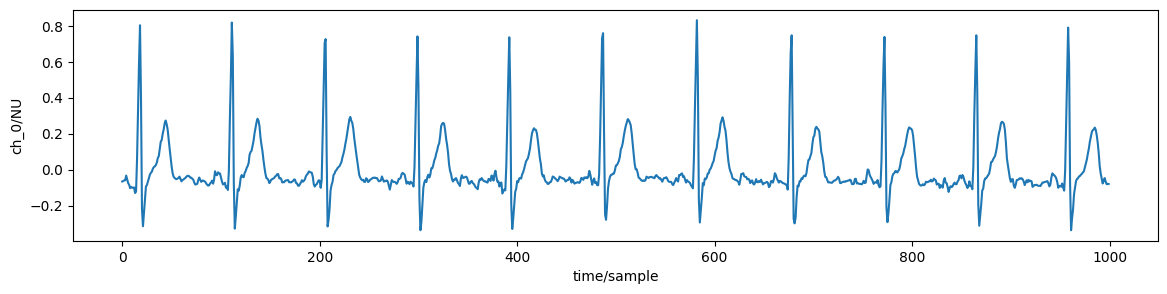

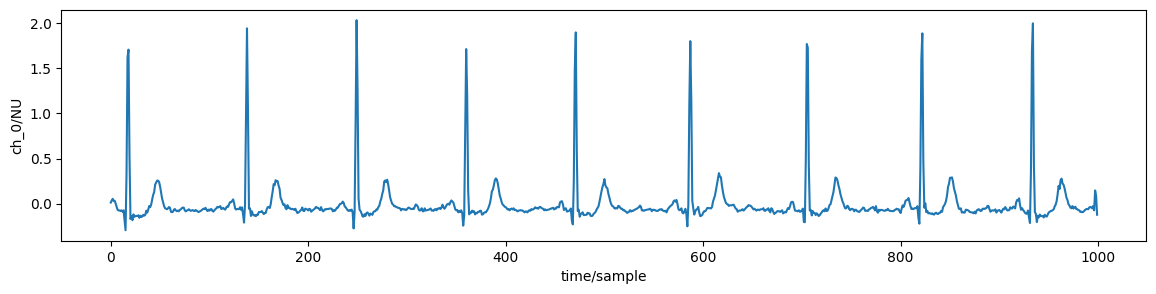

In [7]:
X_train, y_train = aug(X_train, y_train)

### Борьба с дисбалансом классов

In [8]:
X_train, y_train = elimination_imbalance(X_train, y_train)
count_of_class(X_train, y_train)
print(X_train.shape, y_train.shape)

2000
2000
2000
1500
1500
(9000, 1000, 12) (9000, 5)


### Преобразование Фурье

In [9]:
X_train_ft = fourier_transform(X_train)
X_test_ft = fourier_transform(X_test)

### Скользящее среднее

In [10]:
X_train_ra = rolling_average(X_train)
X_test_ra = rolling_average(X_test)

### Стандартизация X_train

In [11]:
X_train_ft_st, X_test_ft_st = standard_scaler(X_train_ft, X_test_ft)
X_train_ra_st, X_test_ra_st = standard_scaler(X_train_ra, X_test_ra)
X_train_st, X_test_st = standard_scaler(X_train, X_test)

In [12]:
del X_train
del X_test

### lstm

In [18]:
num_classes = y_train.shape[1]
model = keras.Sequential()
model.add(layers.LSTM(input_shape=(1000, 12), units=256,
                return_sequences=True,
                stateful=False, unroll=False
))
model.add(layers.LeakyReLU())
model.add(layers.LSTM(units=256,
                return_sequences=False,
                stateful=False, unroll=False
))
model.add(layers.LeakyReLU())
model.add(layers.Dense(units=num_classes, activation='softmax'))
print(model.summary())

# Реализация раннего прекращения.
checkpoint_filepath = './checkpoint_lstm/'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                      save_weights_only=True,
                                                      save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=15,
                                              restore_best_weights=True)

model.compile(loss = keras.losses.CategoricalCrossentropy(),
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

history = model.fit(X_train_st, y_train, 
                      epochs = 100, 
                      validation_data = None, 
                      validation_split=0.1, 
                      callbacks=[model_checkpoint, early_stopping])

# Сохранение модели
model.save('lstm_superdiag_1')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1000, 256)         275456    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 1000, 256)         0         
                                                                 
 lstm_3 (LSTM)               (None, 256)               525312    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 802,053
Trainable params: 802,053
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
254/254 [======================

In [19]:
print('score: ', model.evaluate(X_test_st, y_test))

52/52 [==============================] - 3s 47ms/step - loss: 0.8281 - accuracy: 0.6982
score:  [0.8280635476112366, 0.6981818079948425]


### lstm_bidir

In [20]:
model = keras.Sequential()
model.add(layers.Bidirectional(layers.LSTM(input_shape=(1000, 12), units=256,
                      return_sequences=True,
                      stateful=False, unroll=False
                      )))
model.add(layers.LeakyReLU())
model.add(layers.Bidirectional(layers.LSTM(units=256,
                      return_sequences=False,
                      stateful=False, unroll=False
                      )))
model.add(layers.LeakyReLU())
model.add(layers.Dense(units=num_classes, activation='softmax'))

model.build(input_shape = (None, 1000, 12)) # `input_shape` is the shape of the input data
print(model.summary())

# Реализация раннего прекращения.
checkpoint_filepath = './checkpoint_lstm_bidir/'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                      save_weights_only=True,
                                                      save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=15,
                                              restore_best_weights=True)

model.compile(loss = keras.losses.CategoricalCrossentropy(),
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

history = model.fit(X_train_st, y_train, 
                      epochs = 100, 
                      validation_data = None, 
                      validation_split=0.1, 
                      callbacks=[model_checkpoint, early_stopping])

# Сохранение модели
model.save('lstm_bidir_superdiag_1')


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1000, 512)        550912    
 l)                                                              
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 1000, 512)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 512)              1574912   
 nal)                                                            
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 2,128,389
Trainable params: 2,128,389
No

In [21]:
print('score: ', model.evaluate(X_test_st, y_test))

52/52 [==============================] - 6s 97ms/step - loss: 0.8558 - accuracy: 0.6982
score:  [0.8558298349380493, 0.6981818079948425]


In [22]:
num_classes = y_train.shape[1]
model = keras.Sequential()
model.add(layers.LSTM(input_shape=(1000, 12), units=256,
                return_sequences=True,
                stateful=False, unroll=False
))
model.add(layers.LeakyReLU())
model.add(layers.LSTM(units=256,
                return_sequences=False,
                stateful=False, unroll=False
))
model.add(layers.LeakyReLU())
model.add(layers.Dense(units=num_classes, activation='softmax'))
print(model.summary())

# Реализация раннего прекращения.
checkpoint_filepath = './checkpoint_lstm/'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                      save_weights_only=True,
                                                      save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=15,
                                              restore_best_weights=True)

model.compile(loss = keras.losses.CategoricalCrossentropy(),
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

history = model.fit(X_train_ft_st, y_train, 
                      epochs = 100, 
                      validation_data = None, 
                      validation_split=0.1, 
                      callbacks=[model_checkpoint, early_stopping])

# Сохранение модели
model.save('lstm_superdiag_2')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1000, 256)         275456    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 1000, 256)         0         
                                                                 
 lstm_7 (LSTM)               (None, 256)               525312    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 802,053
Trainable params: 802,053
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
254/254 [======================

In [23]:
print('score: ', model.evaluate(X_test_ft_st, y_test))

52/52 [==============================] - 3s 46ms/step - loss: 1.1310 - accuracy: 0.5800
score:  [1.130974292755127, 0.5799999833106995]


In [ ]:
num_classes = y_train.shape[1]
model = keras.Sequential()
model.add(layers.LSTM(input_shape=(997, 12), units=256,
                return_sequences=True,
                stateful=False, unroll=False
))
model.add(layers.LeakyReLU())
model.add(layers.LSTM(units=256,
                return_sequences=False,
                stateful=False, unroll=False
))
model.add(layers.LeakyReLU())
model.add(layers.Dense(units=num_classes, activation='softmax'))
print(model.summary())

# Реализация раннего прекращения.
checkpoint_filepath = './checkpoint_lstm/'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                      save_weights_only=True,
                                                      save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=15,
                                              restore_best_weights=True)

model.compile(loss = keras.losses.CategoricalCrossentropy(),
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

history = model.fit(X_train_ra_st, y_train, 
                      epochs = 100, 
                      validation_data = None, 
                      validation_split=0.1, 
                      callbacks=[model_checkpoint, early_stopping])

# Сохранение модели
model.save('lstm_superdiag_3')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 997, 256)          275456    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 997, 256)          0         
                                                                 
 lstm_3 (LSTM)               (None, 256)               525312    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 802,053
Trainable params: 802,053
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
254/254 [======================

In [ ]:
print('score: ', model.evaluate(X_test_ra_st, y_test))

In [ ]:
model = keras.Sequential()
model.add(layers.Bidirectional(layers.LSTM(input_shape=(1000, 12), units=256,
                      return_sequences=True,
                      stateful=False, unroll=False
                      )))
model.add(layers.LeakyReLU())
model.add(layers.Bidirectional(layers.LSTM(units=256,
                      return_sequences=False,
                      stateful=False, unroll=False
                      )))
model.add(layers.LeakyReLU())
model.add(layers.Dense(units=num_classes, activation='softmax'))

model.build(input_shape = (None, 1000, 12)) # `input_shape` is the shape of the input data
print(model.summary())

# Реализация раннего прекращения.
checkpoint_filepath = './checkpoint_lstm_bidir/'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                      save_weights_only=True,
                                                      save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=15,
                                              restore_best_weights=True)

model.compile(loss = keras.losses.CategoricalCrossentropy(),
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

history = model.fit(X_train_ft_st, y_train, 
                      epochs = 100, 
                      validation_data = None, 
                      validation_split=0.1, 
                      callbacks=[model_checkpoint, early_stopping])

# Сохранение модели
model.save('lstm_bidir_superdiag_2')


In [ ]:
print('score: ', model.evaluate(X_test_ft_st, y_test))

In [ ]:
model = keras.Sequential()
model.add(layers.Bidirectional(layers.LSTM(input_shape=(1000, 12), units=256,
                      return_sequences=True,
                      stateful=False, unroll=False
                      )))
model.add(layers.LeakyReLU())
model.add(layers.Bidirectional(layers.LSTM(units=256,
                      return_sequences=False,
                      stateful=False, unroll=False
                      )))
model.add(layers.LeakyReLU())
model.add(layers.Dense(units=num_classes, activation='softmax'))

model.build(input_shape = (None, 1000, 12)) # `input_shape` is the shape of the input data
print(model.summary())

# Реализация раннего прекращения.
checkpoint_filepath = './checkpoint_lstm_bidir/'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                      save_weights_only=True,
                                                      save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=15,
                                              restore_best_weights=True)

model.compile(loss = keras.losses.CategoricalCrossentropy(),
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

history = model.fit(X_train_ra_st, y_train, 
                      epochs = 100, 
                      validation_data = None, 
                      validation_split=0.1, 
                      callbacks=[model_checkpoint, early_stopping])

# Сохранение модели
model.save('lstm_bidir_superdiag_3')


In [ ]:
print('score: ', model.evaluate(X_test_ra_st, y_test))